# Bike Sharing Starter Code

In this notebook we will be building a model of bike demand throughout the DC area for Capital Bikeshare. We will primarily be using tree based methods to do this.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# Read in and manipulate the data 

Here we will read in both the training and the testing set. Note that you will need to go to the Kaggle competition to get the data. You can find the Kaggle competition [here](https://www.kaggle.com/c/bike-sharing-demand).

In [3]:
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [5]:
train_df.tail(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10876,2012-12-19 14:00:00,4,0,1,1,17.22,21.210,50,12.9980,33,185,218
10877,2012-12-19 15:00:00,4,0,1,1,17.22,21.210,50,19.0012,28,209,237
10878,2012-12-19 16:00:00,4,0,1,1,17.22,21.210,50,23.9994,37,297,334
10879,2012-12-19 17:00:00,4,0,1,1,16.40,20.455,50,26.0027,26,536,562
10880,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,23,546,569
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


How many rows and columns do we have?

In [6]:
train_df.shape

(10886, 12)

In [7]:
test_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


How many rows and columns do we have for the test data?

In [8]:
test_df.shape

(6493, 9)

Why do we have fewer columns? Is that a problem?

Now let's summarize our dataframes.

In [9]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [10]:
summarize_dataframe(train_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,object,0,10886,10886.0,10886,2011-01-01 00:00:00,1,,,,,,,
season,int64,0,4,10886.0,,,,2.506614,1.116174,1.0,2.0,3.0,4.0,4.0
holiday,int64,0,2,10886.0,,,,0.028569,0.166599,0.0,0.0,0.0,0.0,1.0
workingday,int64,0,2,10886.0,,,,0.680875,0.466159,0.0,0.0,1.0,1.0,1.0
weather,int64,0,4,10886.0,,,,1.418427,0.633839,1.0,1.0,1.0,2.0,4.0
temp,float64,0,49,10886.0,,,,20.23086,7.79159,0.82,13.94,20.5,26.24,41.0
atemp,float64,0,60,10886.0,,,,23.655084,8.474601,0.76,16.665,24.24,31.06,45.455
humidity,int64,0,89,10886.0,,,,61.88646,19.245033,0.0,47.0,62.0,77.0,100.0
windspeed,float64,0,28,10886.0,,,,12.799395,8.164537,0.0,7.0015,12.998,16.9979,56.9969
casual,int64,0,309,10886.0,,,,36.021955,49.960477,0.0,4.0,17.0,49.0,367.0


In [11]:
summarize_dataframe(test_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,object,0,6493,6493.0,6493,2011-01-20 00:00:00,1,,,,,,,
season,int64,0,4,6493.0,,,,2.4933,1.091258,1.0,2.0,3.0,3.0,4.0
holiday,int64,0,2,6493.0,,,,0.029108,0.168123,0.0,0.0,0.0,0.0,1.0
workingday,int64,0,2,6493.0,,,,0.685815,0.464226,0.0,0.0,1.0,1.0,1.0
weather,int64,0,4,6493.0,,,,1.436778,0.64839,1.0,1.0,1.0,2.0,4.0
temp,float64,0,49,6493.0,,,,20.620607,8.059583,0.82,13.94,21.32,27.06,40.18
atemp,float64,0,65,6493.0,,,,24.012865,8.782741,0.0,16.665,25.0,31.06,50.0
humidity,int64,0,79,6493.0,,,,64.125212,19.293391,16.0,49.0,65.0,81.0,100.0
windspeed,float64,0,27,6493.0,,,,12.631157,8.250151,0.0,7.0015,11.0014,16.9979,55.9986


Are the 'datetime' columns in proper datetime format? Currently not. Pandas doesn't know that the datetime column is a date. It just thinks it is a string until we tell it that it is a date. Let's do that.

Convert the datetime columns to proper datetime format, and rerun the cells above to see if the conversion took.

In [12]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Feature Engineering and Variable Selection

From the datetime column, we extract year, month, hour, and day of week (DOW), and then add these features to the data frames as new variables. Remember, anything we do to the training data set, we are also going to want to do to the testing data set so that our test data looks similar to our training data come test time.

In [13]:
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['hour'] = train_df['datetime'].dt.hour
train_df['DOW'] = train_df['datetime'].dt.dayofweek

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['hour'] = test_df['datetime'].dt.hour
test_df['DOW'] = test_df['datetime'].dt.dayofweek

In [14]:
train_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,DOW
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4,5
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,5,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,6,5
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,7,5
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,8,5
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,9,5


These variables are likely to be very useful in predicting our final count because similar hours of the day are likely to have similar counts. Same for days of the week or months of the year. However, this is just a brief start to what can be done with feature engineering. What other features might we make? This is a way in which a "small data" problem (i.e. one with few columns) can quickly turn into a "big data" problem. It's also a very effective way to improve a models performance.

To get started, we will train our models on the variables 'workingday', 'temp', 'year', 'month', 'hour', and 'DOW'. The variable 'count' is the quantity we are trying to predict. It is often useful to create a list of the variables that you want to use.

In [15]:
ind_variables_selected = ['workingday', 'temp', 'year', 'month', 'hour', 'DOW']

In [16]:
X_orig_train = train_df[ind_variables_selected]
y_orig_train = train_df['count']

In [17]:
X_test = test_df[ind_variables_selected]

We don't create a `y_test`. Why is that?

Note that the way we selected variables seems much simpler than what we had to do with regularlized linear regression. Why might that be? Note that you can still create interactions and dummy variables with this data set, if you would like. You should explore how you might best engineer features for this problem.

#  Create smaller training and validation sets

In order to evaluate our models, let's split the original training set into a 75% smaller training set and a 25% validation set.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_orig_train, y_orig_train, test_size = 0.25, random_state = 201)

In [19]:
X_train.head()

,workingday,temp,year,month,hour,DOW
7131,0,26.24,2012,4,12,6
8966,1,27.88,2012,8,23,2
3606,1,22.96,2011,9,4,3
5160,1,9.84,2011,12,2,4
9766,1,14.76,2012,10,7,3


How much training data do we have left?

In [20]:
X_train.shape

(8164, 6)

In [21]:
X_valid.head()

,workingday,temp,year,month,hour,DOW
7483,1,17.22,2012,5,4,4
5124,1,18.04,2011,12,14,2
7439,1,24.60,2012,5,8,2
2535,1,28.70,2011,6,13,0
4729,1,15.58,2011,11,3,3


And validation data?

In [22]:
X_valid.shape

(2722, 6)

# Set Up the Evaluation Metric

Kaggle uses Root Mean Squared Logarithmic Error (RMSLE) for scoring (or evaluation). See this link for details: https://www.kaggle.com/c/bike-sharing-demand/details/evaluation. Why do they choose RMSLE and not RMSE? Below is a function for calculating RMSLE. The clip method truncates values below 0.

In [23]:
def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

Now we can define our accuracy function and add RMSLE to it.

In [24]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)],
                                  "RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

# Fit a Regression Tree

A regression tree is a way to successively split the data into smaller and smaller subgroups, and then use the average of the data in each subgroup to make predictions. Read section 8.1 in Introduction to Statistical Learning (ISL) for a full discussion of regression trees.

A regression tree has a few possible parameters that can be tuned.
  * `max_depth`: This sets the maximum number of splits between the top of the tree and any leaf. A smaller number means a smaller tree, and therefore a tree that is less likely to overfit.
  * `min_samples_split`: This sets the number of samples that must be in a leaf for the leaf to be a candidate for a split. A larger number means a smaller tree. This must be greater than or equal to 2.
  * `min_samples_leaf`: This is identical to `min_samples_split`, but this is how many samples have to be left in each leaf after the split. This must be greater than or equal to 1. Generally, you tune either `min_samples_leaf` or `min_samples_split`, not both. They do such similar things that it is quite redundant.
  * `max_features`: This is a parameter that tunes how many features a regression tree will consider when it is splitting a node. A value between 0 and 1 will tell it to use only a random fraction of the possible nodes when it's considering a split. E.g., if you have 10 variables, and you set this to `.3`, then each time the algorithm is deciding to split a leaf, it will pick three random variables and only select from one of those. This will keep a tree from focusing too heavily on certain variables by forcing it to include information from other variables in the decision process. A smaller value means a tree that is generally less likely to overfit. If you set it to `None`, then it will consider all variables at each split (this is the default).
  * `min_impurity_decrease`: This parameter sets how much the evaluation criteria has to go down before it will split a node. A larger value means there is a higher threshold before a node can be split, so this will lead to a smaller (and less overfit) tree.
  * `ccp_alpha`: This is the _cost complexity pruning alpha_ discussed in Chapter 8.1 of ISL on tree pruning. The higher the `ccp_alpha`, the more pruning will happen on the tree and the more regularized the tree will be. The default value is `0`, which implies that the tree will not be pruned. Another discussion can be found [here](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

It is very helpful to play around with these parameters to get a sense for what they do. For more information, you can find the documenation for the `sklearn` implementation of `DecisionTreeRegressor` [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Note that you don't have to set all of these parameters. They have default values, and you can leave them at the default.

In [25]:
rt = DecisionTreeRegressor(max_depth=500,
                           min_samples_split=25,
                           max_features=.5,
                           min_impurity_decrease=.001,
                           ccp_alpha=10,
                           random_state=201)
rt_model = rt.fit(X_train, y_train)
rt_pred = rt_model.predict(X_valid)

A way to get an intuitive sense for what these parameters do is to plot the decision tree. You should change the variables above and observe how the plot changes.

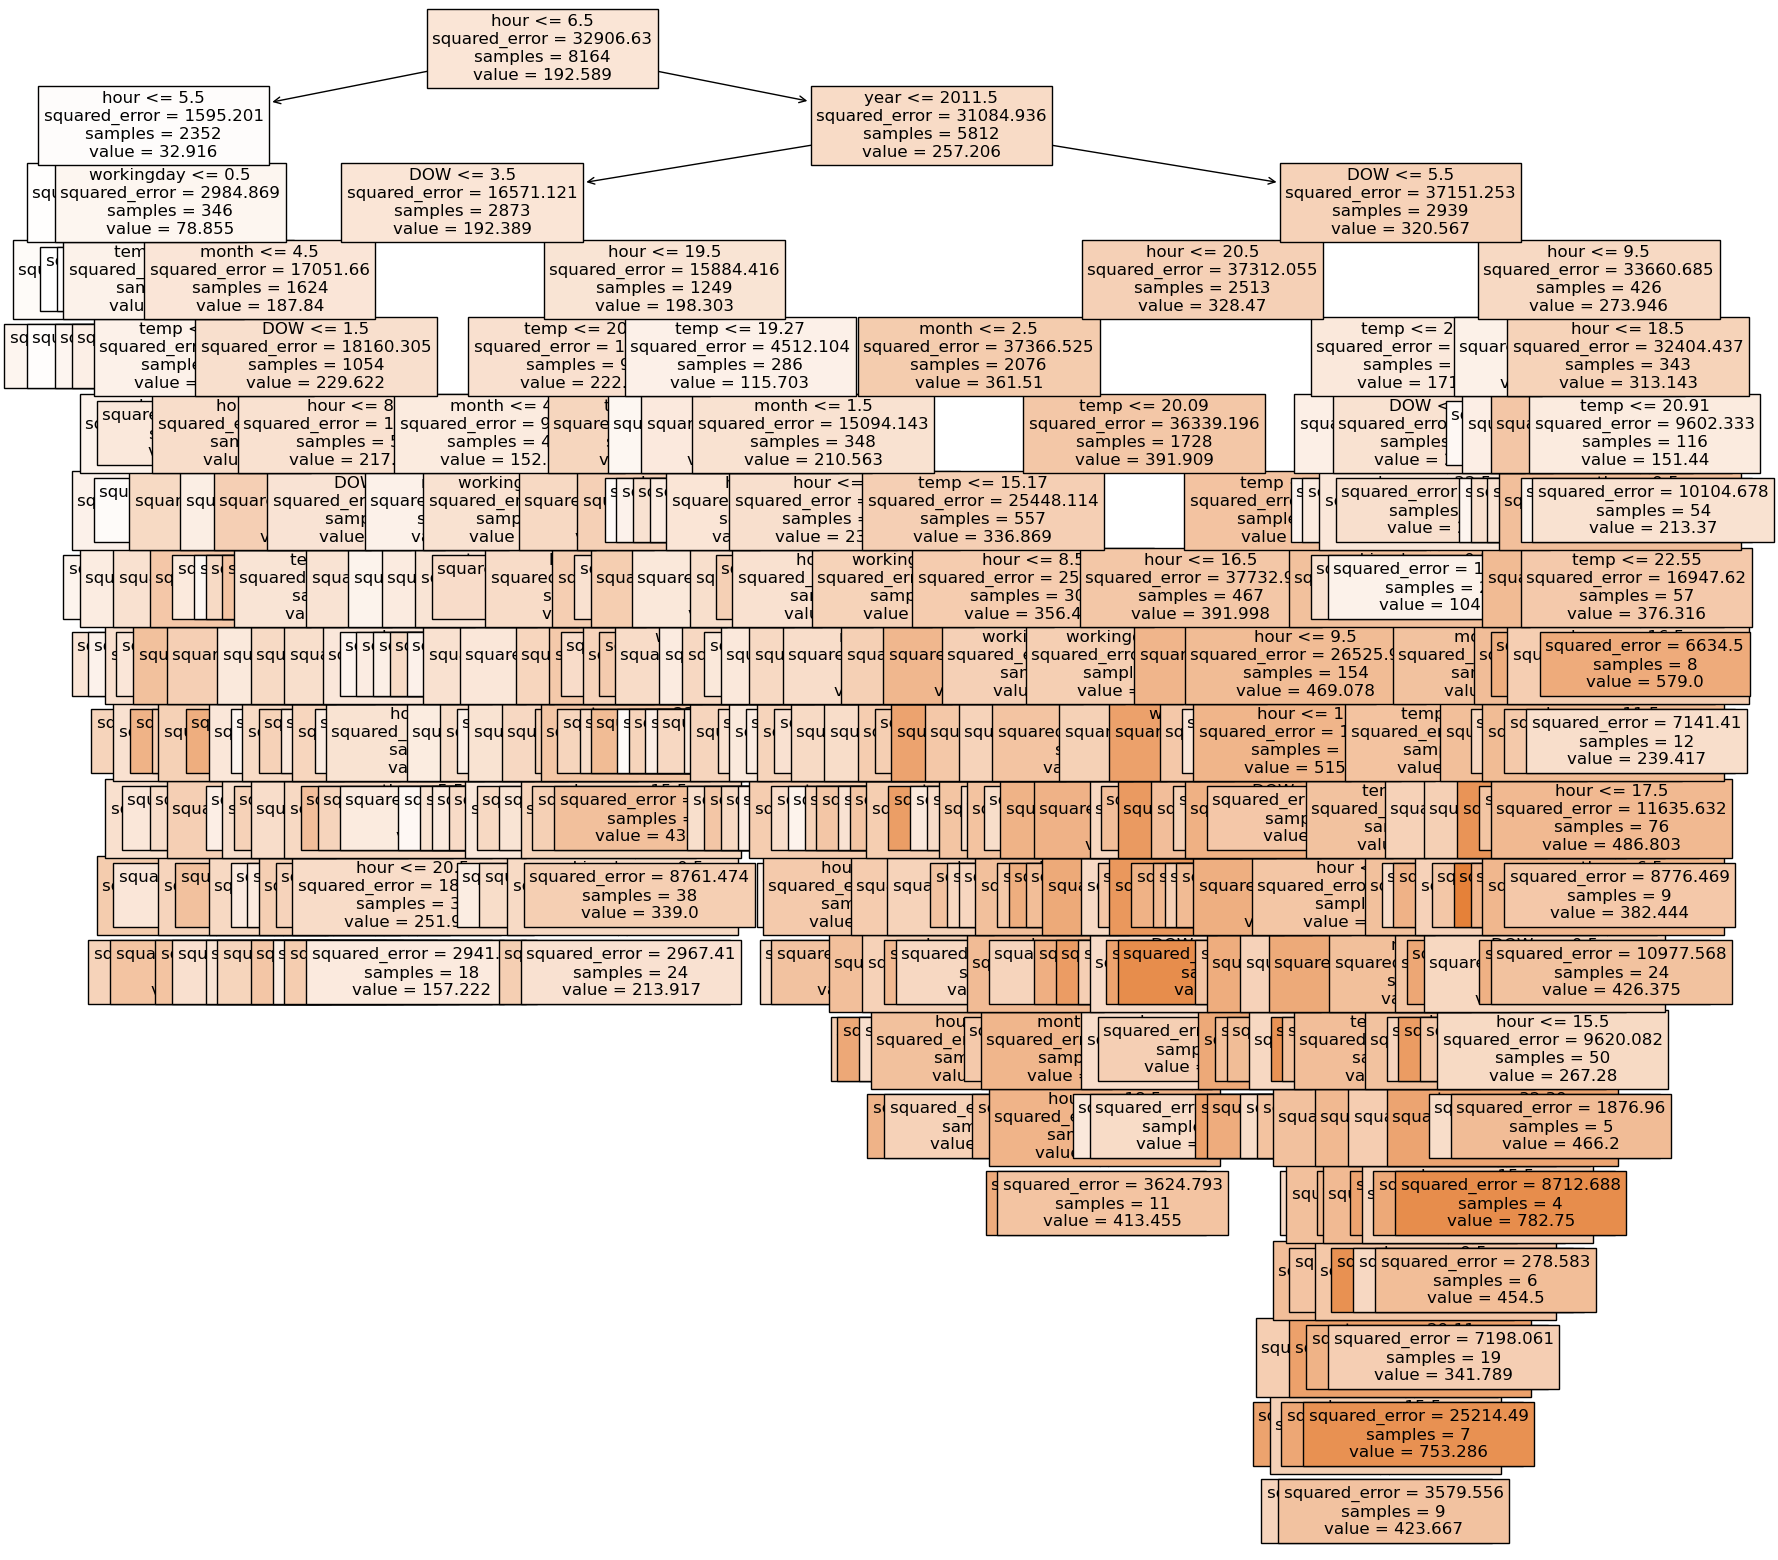

In [26]:
plt.figure(figsize=(20,20))
plot_tree(rt_model, feature_names=X_train.columns.to_list(), filled=True, fontsize=12)
plt.show()

Look at the importances of the variables (or features). Which feature is the most important? The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the mean squared error (MSE) brought by that feature. Put another way, the importance of the feature is equal to how much the MSE would increase if we took that feature entirely out of the data set but left everything else in. What are the most important features?

We can also look at the importance of various features using the below function.

In [27]:
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

In [28]:
get_tree_importances(rt, X_train)

,Importance
hour,0.699387
year,0.104229
month,0.095768
temp,0.065389
workingday,0.018939
DOW,0.016288


Plot the tree's predictions vs. actuals. Where should all of the points fall?

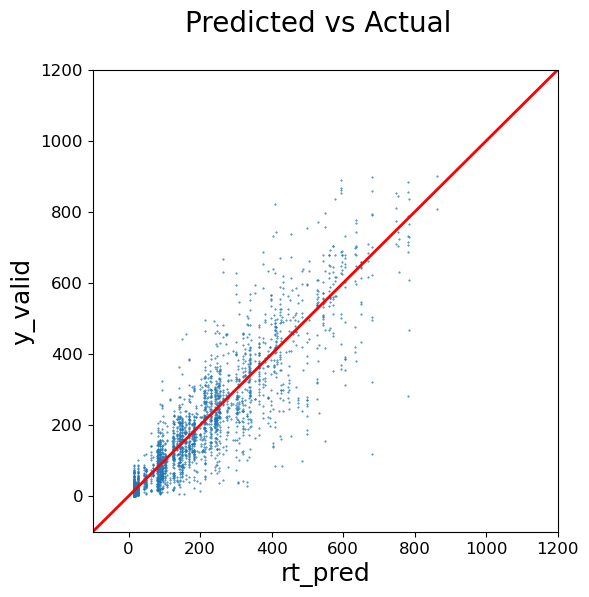

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(rt_pred, y_valid, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rt_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

What is the accuracy of the regression tree? Which metric should we care about?

In [30]:
accuracy(y_valid, rt_pred)

RMSE,MAE,R^2,RMSLE
78.823235,51.220346,0.808881,0.644142


In [31]:
rt_pred1 = rt_model.predict(X_train)

In [32]:
accuracy(y_train, rt_pred1)

RMSE,MAE,R^2,RMSLE
69.682614,46.955091,0.852441,0.623694


# Fit a random forest

A random forest is just the average of a bunch of regression trees. For a full discussion, read ISL 8.2.1/8.2.2. Given that the random forest fits a bunch of regression trees, it has all of the same parameters as a regression tree (since each regression tree must individually be fit), but some of them take on more importance. With a regression tree, we need to tune the tree so that the single one we have does really well. With a random forest, the goal is to have them do well on average (take advantage of the wisdom of crowds), so we likely will want each of our individual trees to be significantly simpler in our random forest then with the regression tree. We also want our trees to be diverse (i.e., we don't want them all to make the same mistakes). The best way to do that is to force them to use different features using the `max_features` parameter. While we can tune `max_features` for an individual regression tree, it becomes much more important for a random forest.

The random forest has one additional parameter that the regression tree doesn't have, `n_estimators`, or the number of trees in the forest. Do you need to worry about overfitting if you have too many trees? Think about this and come to class prepared to discuss.

We will also set a parameter called `n_jobs` which is just the number of trees it can train simultaneously. This should be set to the number of cpu cores you have access to, which we assigned to the variable `num_cpus` earlier in the notebook.

<img src="images/Random_Forest.png" width="600"/>

In [33]:
rf = RandomForestRegressor(n_estimators=500,
                           max_features=4,
                           min_samples_leaf=5,
                           random_state=201,
                           ccp_alpha=10,
                           n_jobs=num_cpus)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_valid)

We can plot the importance just like with a regression tree.

In [34]:
get_tree_importances(rf, X_train)

,Importance
hour,0.651020
temp,0.118847
year,0.092709
month,0.054598
DOW,0.043035
workingday,0.039789


Let's plot the predictions versus the actual realizations.

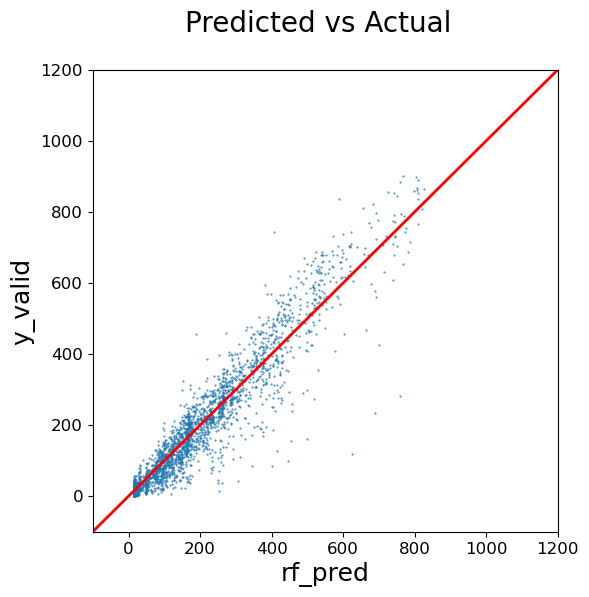

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(rf_pred, y_valid, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rf_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

What is the accuracy of the model?

In [36]:
accuracy(y_valid, rf_pred)

RMSE,MAE,R^2,RMSLE
56.573595,36.964753,0.901548,0.569714


# Fit a boosted trees model

A boosted tree iteratively fits trees where each tree tries to correct the errors of all of the previous trees (summed together). This is a very powerful machine learning technique, and read ISL 8.2.3. Boosted trees have some of the same parameters as regression trees, but sometimes the names are a little different. The paramaters that you are most likely to want to tune are:
  * `n_estimators`: This is the number of trees used for the final model. The more trees, the more likely the model is to overfit.
  * `learning_rate`: This is a parameter that determines how much weight is given to each tree (it is the lambda in ISL). The larger this number, the more likely the model is to overfit.
  * `max_depth`: This is the same as `max_depth` for a regression tree.
  * `min_split_loss`: This is the same as `min_impurity_decrease` for a regression tree.

Other good references are available at https://xgboost.readthedocs.io/en/latest/index.html, https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn, and https://xgboost.readthedocs.io/en/latest/tutorials/model.html.

<img src="images/gradient-boosted-regression-trees-632x238.png" width="800"/>

In [37]:
xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         random_state=201)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)

Get the unnormalized feature importance scores.

In [38]:
get_tree_importances(xgb_model, X_train)

,Importance
hour,0.373474
workingday,0.226393
year,0.174821
temp,0.110014
month,0.060681
DOW,0.054616


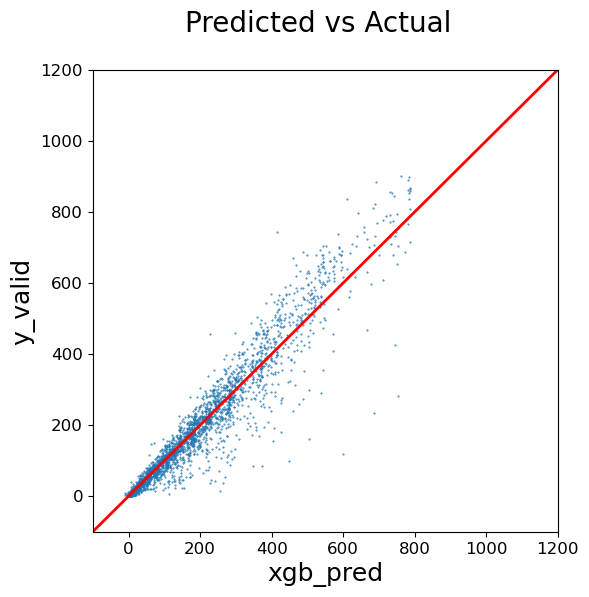

In [39]:
plt.figure(figsize=(6,6))
plt.scatter(xgb_pred, y_valid, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('xgb_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

What is the accuracy of the boosted tree?

In [40]:
accuracy(y_valid, xgb_pred)

RMSE,MAE,R^2,RMSLE
53.021251,31.494214,0.913524,0.407062


## Grid Search to Optimize Parameters

For all of the tree based models, there are a number of parameters that can be optimized, and they do not interact in simple ways. For example, if you train a regression tree, you may be able to increase the `max_depth` parameter as long as you also increase the `min_samples_split` parameter at the same time. Alternatively, if you are training a boosted tree, you may be able to increase `n_estimators` as long as you decrease the `learning_rate`.

It is very difficult to predict what the optimal set of parameters will be. Often, the only way to proceed is to guess a bunch of parameters at random and try them until you get a better model. This is terribly tedious and boring. Luckily computers are really good at tedious and boring tasks!

We will use a very important function from `sklearn` called `GridSearchCV`. This function will try all possible values of a "grid" of parameters, potentially hundreds to thousands of combinations if you allow the computer to run for long enough. When you are trying so many different parameters, there is a very real danger of overfitting if you are not careful. The way that `GridSearchCV` avoids this is by testing each parameterization **out of sample**, while still using the whole training dataset for the test, by using **cross validation** (for a refresher on this, refer to ISL Section 5.1).

To specify which parameters `GridSearchCV` should look at, you need to give it a _dictionary_ of the relevant parameters with the _key_ being the parameter name and the value being a _list_ of the values you would like `GridSearchCV` to try. Below is a potential example to search through three of the parameters for a regression tree.

In [41]:
parameters = {'max_depth': [3, 5, 10, 15, 25, 35, 50],
              'min_samples_split': [5, 10, 25, 75, 100, 125],
              'min_impurity_decrease': [0, .001, .01, .1, 1, 10]}

This may seem like a relatively small list of parameters, but this list will mean that a model is trained for every combination of the three parameters. Since there are `7*7*6=252` combinations, there will be 252 different models trained (and each model will be trained for each cut of the cross validation, so 4 fold cross validation, there will be 1008 models trained), and the best will be selected based on an evaluation criteria.

Note also that we did not provide values for all parameters. We can specify some in the model like normal, and then let it search over others.

We can see the list of parameters that will be tried with the below code, and it should give an idea of how quickly this approach can get out of hand.

In [42]:
from sklearn.model_selection import ParameterGrid
list(ParameterGrid(parameters))

[{'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 5},
 {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 10},
 {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 25},
 {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 75},
 {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 100},
 {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_split': 125},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 5},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 10},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 25},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 75},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 100},
 {'max_depth': 3, 'min_impurity_decrease': 0.001, 'min_samples_split': 125},
 {'max_depth': 3, 'min_impurity_decrease': 0.01, 'min_samples_split': 5},
 {'max_depth': 3, 'min_impurity_decr

This should also give some insight into why large scale computing resources are needed. It is not always the case that building a single model will take a long time, but to find the right model, you might have to build thousands along the way.

In order to use `GridSearchCV` (more documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)), we need to tell it what kind of model it should search over, the parameter grid it should try, and the number of folds in the cross fold validation (parameter `cv`). Additionally, we can tell it how many cpu cores it should use just like in the random forest example.

In [43]:
gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features = .5, ccp_alpha=10, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus)

Then we just fit the grid search regression tree just like normal. This may take a while due to how many parameters you give it.

In [44]:
gs_rt_model.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=10, max_features=0.5,
                                             random_state=201),
             n_jobs=2,
             param_grid={'max_depth': [3, 5, 10, 15, 25, 35, 50],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1, 10],
                         'min_samples_split': [5, 10, 25, 75, 100, 125]})

We can then determine the best parameters it chose.

In [45]:
gs_rt_model.best_params_

{'max_depth': 25, 'min_impurity_decrease': 0.1, 'min_samples_split': 5}

And we can predict with it where it has retrained the model on the full training set using the best parameters it found.

In [46]:
gs_rt_pred = gs_rt_model.predict(X_valid)

In [47]:
accuracy(y_valid, gs_rt_pred)

RMSE,MAE,R^2,RMSLE
69.540241,45.866059,0.851246,0.635990


Note that the RMSLE is not necessarily all that low. One of the problems is that it chose the best model with the default scoring criterion of the `DecisionTreeRegressor` which happens to be the mean squared error (equivalently, the RMSE). We really want to pick the best model based on the RMSLE. We can tell `GridSearchCV` to use our `RMSLE` function to evaluate models instead. Let's see that.

In [48]:
gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features=.5, ccp_alpha=10, random_state=201),
                           param_grid=parameters,
                           cv=4,
                           n_jobs=num_cpus,
                           scoring=make_scorer(RMSLE, greater_is_better=False))

In [49]:
gs_rt_model.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=10, max_features=0.5,
                                             random_state=201),
             n_jobs=2,
             param_grid={'max_depth': [3, 5, 10, 15, 25, 35, 50],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1, 10],
                         'min_samples_split': [5, 10, 25, 75, 100, 125]},
             scoring=make_scorer(RMSLE, greater_is_better=False))

In [50]:
gs_rt_model.best_params_

{'max_depth': 15, 'min_impurity_decrease': 0.1, 'min_samples_split': 25}

Our model only changed a little bit, but it did change. Let's predict and then look at the accuracy.

In [51]:
gs_rt_pred = gs_rt_model.predict(X_valid)

In [52]:
accuracy(y_valid, gs_rt_pred)

RMSE,MAE,R^2,RMSLE
81.656056,52.905838,0.794897,0.634025


In this case, RMSLE actually went up by a little bit after we optimized for the objective. However, generally you will do better by optimizing for the right objective, at least by a little bit.

This methodology can be used to optimize any `sklearn`-like function. You can use the same approach with `XGBRegressor` even though `XGBRegressor` is not actually an `sklearn` function because it uses the "sklearn style" or more precisely, the `sklearn` API.

While this is a very, very powerful technique, given how easy it is to scale up the size of the grid to something that will take hundreds of years for the computer to finish searching through, it's always smart to run `GridSearchCV` on a smaller set and timing it before you scale it up, like below.

In [53]:
%%time
gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features=.5, ccp_alpha=10, random_state=201),
                           param_grid=parameters,
                           cv=4,
                           n_jobs=num_cpus,
                           scoring=make_scorer(RMSLE, greater_is_better=False))
gs_rt_model.fit(X_train, y_train)

CPU times: user 277 ms, sys: 10.6 ms, total: 288 ms
Wall time: 3.61 s


GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=10, max_features=0.5,
                                             random_state=201),
             n_jobs=2,
             param_grid={'max_depth': [3, 5, 10, 15, 25, 35, 50],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1, 10],
                         'min_samples_split': [5, 10, 25, 75, 100, 125]},
             scoring=make_scorer(RMSLE, greater_is_better=False))

This only took a few seconds, so you could probably increase the number of parameter combinations you tried by quite a few and still get an answer back in a reasonable time. However, there are some parameters that increase the run time (like `n_estimators` for boosted trees or random forests), so you need to be a little careful.

After you have found the best parameters on the smaller training set, you will likely want to retrain on the whole training set (by adding the validation data back in). You probably don't want to re-do the grid search because it can take a long time, so you can just use the parameters you found from the smaller training `GridSearchCV` training, like below.

In [54]:
gs_rt_model.best_params_

{'max_depth': 15, 'min_impurity_decrease': 0.1, 'min_samples_split': 25}

In [55]:
rt_model_retrain = DecisionTreeRegressor(max_features=.5, **gs_rt_model.best_params_)

The `**` unpacks the dictionary of `best_params_` into arguments for the function, so effectively the above becomes `DecisionTreeRegressor(max_features=.5, max_depth=15, min_impurity_decrease=0.01, min_samples_split=10)`. Then you just need to fit it, like below.

In [56]:
rt_model_retrain.fit(X_orig_train, y_orig_train)

DecisionTreeRegressor(max_depth=15, max_features=0.5, min_impurity_decrease=0.1,
                      min_samples_split=25)

Best of luck finding the best parameters for your model!

## Advanced Topic - Saving Your Model for Later

Particularly when you have spent a long time searching for the optimal parameters, it can be computationally prohibitive to need to re-run the model everytime that you want to use the model. This is especially true when you may want to train a few different models in order to ensemble them. In order to avoid having to retrain the models, we can save the models for later. In python, this is called "pickling". We use a package called `dill` to "pickle" things in python (programmers tend to be a little cheeky). We can pickle the `rt_model_retrain` that we fitted above using the below code.

In [57]:
with open("rt_model_retrain_pickled.pkl", 'wb') as f:
    dill.dump(rt_model_retrain, f)

Now anytime that we want to use the model again, we can just load it from the file (assuming we've already imported pickle) using the below code.

In [58]:
with open("rt_model_retrain_pickled.pkl", 'rb') as f:
    rt_model_reloaded = dill.load(f)

The `with open("rt_model_retrain_pickled.pkl", 'rb') as f:` code just means that we want python to read (that's the `r`) a binary file (a file with just `0`s and `1`s, which is indicated by the `b`) called `"rt_model_retrain_pickled.pkl"` and we'll refer to that file as `f`. The `with` part just means to only keep the file open while we run the indented piece of code, and then to close the file. When we are pickling instead of reading, we use a `w` instead of `r` to indicate that we want to write instead of read.

We can then check and make sure it worked by trying to predict on the validation data after loading in the model.

In [59]:
rt_model_reloaded.predict(X_valid)

array([  7.07100592,  93.31818182, 514.53333333, ..., 209.8       ,
       356.46153846, 137.57894737])

In [60]:
rt_model_retrain.predict(X_valid)

array([  7.07100592,  93.31818182, 514.53333333, ..., 209.8       ,
       356.46153846, 137.57894737])

Since both gives us the same thing, we succesfully pickled and loaded the model from a file. You may not ever need to use this for this class, but it is a trick that is good to know in case you find yourself training a model that takes a really long time and you'd like to avoid having to retrain it.

## Make predictions in the testing set

Once you have chosen a model (including determining which parameters to use for the model) or models (in the case you intend to ensemble different models), it is time to retrain the model on the original training set. This allows you to use all of the data possible to build the best model. Note that you should do this after you have chosen your parameters using the validation set. For this block of code, I'm going to assume that you are going to go with the boosted trees model (parameters `max_depth=6, n_estimators = 50, learning_rate=.1`) we trained above ensembled with the regression tree model we tuned with `GridSearchCV` (optimal parameters found were `max_features=.5, max_depth=15, min_impurity_decrease=0.01, min_samples_split=10`). First, we will train models with those parameters, and then we will predict on the test data.

In [61]:
rt_model_final = DecisionTreeRegressor(max_features=.5, max_depth=15, min_impurity_decrease=0.01, min_samples_split=10, random_state=201)
rt_model_final.fit(X_orig_train, y_orig_train)

DecisionTreeRegressor(max_depth=15, max_features=0.5,
                      min_impurity_decrease=0.01, min_samples_split=10,
                      random_state=201)

Now we will retrain the boosted trees model.

In [62]:
xgb_model_final = XGBRegressor(max_depth=6, n_estimators = 50, learning_rate=.1, random_state=201)
xgb_model_final.fit(X_orig_train, y_orig_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=201, ...)

Now we can predict on the testing set.

In [63]:
rt_final_pred = rt_model_final.predict(X_test)
xgb_final_pred = xgb_model_final.predict(X_test)

Once we have our predictions we can ensemble them. There are lots of ways to do this, but if we just want to average the two models, it is enough to just add the predictions together and divide by 2 (since this is all an average is). Before we average them, we'll make sure that our predictions are above 0 by clipping them with the `.clip()` method. If we accidentally predict something below 0, it can mess up the RMSLE (since you can't put a negative number into a log function). All clip does is it takes any number in the series below 0 and sets it to 0. Since we are predicting counts of bike riders, obviously negative numbers don't make sense. So, this is good practice when making final predictions when you are going to be evaluated on RMSLE.

In [64]:
final_pred = (rt_final_pred.clip(0) + xgb_final_pred.clip(0))/2

# Competition entries (write to csv)

Finally, we need to prepare the Kaggle submission in the right format. We first read in the `sampleSubmission.csv` which we downloaded from Kaggle.

In [65]:
sample_submission = pd.read_csv('sampleSubmission.csv')

In [66]:
sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


Note that the counts are all `0`. We will replace them with our predictions.

In [67]:
sample_submission['count'] = final_pred

We can see that it worked.

In [68]:
sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.659615
1,2011-01-20 01:00:00,6.085453
2,2011-01-20 02:00:00,2.363665
3,2011-01-20 03:00:00,1.398072
4,2011-01-20 04:00:00,1.398072


Now we will write these out to a csv file in the format that Kaggle expects. Note that if you open the submission file in excel and then save it, excel will mess something up and Kaggle will not accept the submission. If you open your submission file in excel to check what's in there, just be sure not to save it afterwards.

In [69]:
sample_submission.to_csv('finalSubmission.csv', index=False)

In [70]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree regression model
rt_model_final = DecisionTreeRegressor(max_depth=6, min_samples_leaf=5, random_state=201)
rt_model_final.fit(X, y)

# Visualize a decision tree with a specific max_depth
plt.figure(figsize=(12, 6))
plot_tree(rt_model_final, max_depth=3, filled=True)
plt.show()

# Example 2: Visualizing a Classification Decision Tree
# Load an example classification dataset (e.g., Iris)
iris = load_iris()
X, y = iris.data, iris.target

# Train a classification decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Visualize the classification tree with class labels
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names.tolist())
plt.show()


NameError: name 'X' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Create a decision tree model
rt_model_final = DecisionTreeRegressor(max_depth=6, min_samples_leaf=5, random_state=201)
rt_model_final.fit(X, y)

# Visualize the decision tree with a specific max_depth
plt.figure(figsize=(12, 6))
plot_tree(rt_model_final, max_depth=3, filled=True)
plt.show()

In [ ]:
pip install graphviz


In [ ]:
# Import the necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Split your data into training and testing sets (X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosted Tree regressor
gbm_regressor = GradientBoostingRegressor(
    n_estimators=100,  # Number of boosting stages (you can adjust this)
    learning_rate=0.1,  # Step size shrinkage for each stage
    max_depth=3,  # Maximum depth of individual trees
    random_state=42  # Seed for reproducibility
)

# Ensure that X_train is a Pandas DataFrame
X_train = pd.DataFrame(X_train)

# Get the feature names from your training data
feature_names = X_train.columns.tolist()

# Fit the model to your training data
gbm_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbm_regressor.predict(X_test)

# Evaluate the model's performance (you can use different metrics)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get the feature names from your training data
feature_names = X_train.columns.tolist()

# Visualize the first tree in the Gradient Boosted Tree model
plt.figure(figsize=(20, 10))
plot_tree(gbm_regressor.estimators_[0][0], filled=True, feature_names=feature_names)
plt.show()

Now that the competition has ended, it will not give you your rank on the leaderboard, but it will give you your score. Look through the leaderboard to find where you score would have ranked. Come to class with your rank on the Kaggle leaderboard!